In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion

import sim_template as sim
from importlib import reload 

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#Setup the system:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
qBase = np.array([[2,10],[18,10]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 20
x_min = 0
y_max = 20
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 15
p_th = 0.7
n=1

In [4]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH)





Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [5]:
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs
#%store trismall_pcs
print(prob_pred_con)




Drawing 900 samples from Channel 1
Completed PredictedChannel 1
Drawing 900 samples from Channel 2
Completed PredictedChannel 2
[0.9060810810810811]


In [6]:
for pth in [0.5, 0.6, 0.7, 0.8, 0.9]:
    pred_joint_con_fields = [1*(pfs[i*2]*pfs[(i*2)+1]>pth) for i in range(len(ccs)//2)]

    pred_joint_con_pts = [ sim.field_to_pts(pred_joint_con_fields[i], ccs[i*2].region, res) for i in range(len(ccs)//2)]

    #calculate the probabilty of the point being in the predicted regions
    p_pred_connected = []
    for i in range(len(ccs)//2):
        #convert pred points back to grid points, but in res resolution
        idxs = sim.toGridFromRaw(ccs[(i*2)].region, res, pred_joint_con_pts[i])
        print(sim.prob_pred_in_true(true_joint_con_fields[i], idxs))
        
    raw_area = len(pred_joint_con_pts[0])*(1/res)**2
    print('Original area: %.2f'%(raw_area))
    if raw_area != 0:

        pt_cld = PC.PointCloud(pred_joint_con_pts[0])
        pt_cld.partition()
        reduced_area = 0
        n_cnvx = 0
        if pt_cld.polygons is not None:
            for poly in pt_cld.polygons:
                reduced_area += poly.area()
                n_cnvx += len(poly.cnvx_partition)
            print('Area after reduction: %.2f'%(reduced_area))
            print('Number of Convex Polygons in Partition: %d'%(n_cnvx))
            print('percent decrease: %.2f'%((raw_area - reduced_area)/raw_area))
    print('\n\n')

0.7923716661887009
Original area: 31.00
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([9.6        8.13333333])  ([9.66666667 8.        ]) 
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
17 total subregions
Area after reduction: 29.32
Number of Convex Polygons in Partition: 17
percent decrease: 0.05



0.8560484589346161
Original area: 24.95
Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
14 total subregions
Area after reduction: 23.68
Number of Convex Polygons in Partition: 14
percent decrease: 0.05



0.9060810810810811
Original area: 19.73
Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
12 total subregions
Area after reduction: 18.72
Number of Convex Polygons in Partition: 12
percent decrease: 0.05



0.9395050412465628
Original area: 14.55
Extracted edges...
Polygons constructed, looking for holes...
Cons

In [7]:
pt_cld = PC.PointCloud(pjcps[0])
pt_cld.partition()


Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
12 total subregions


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


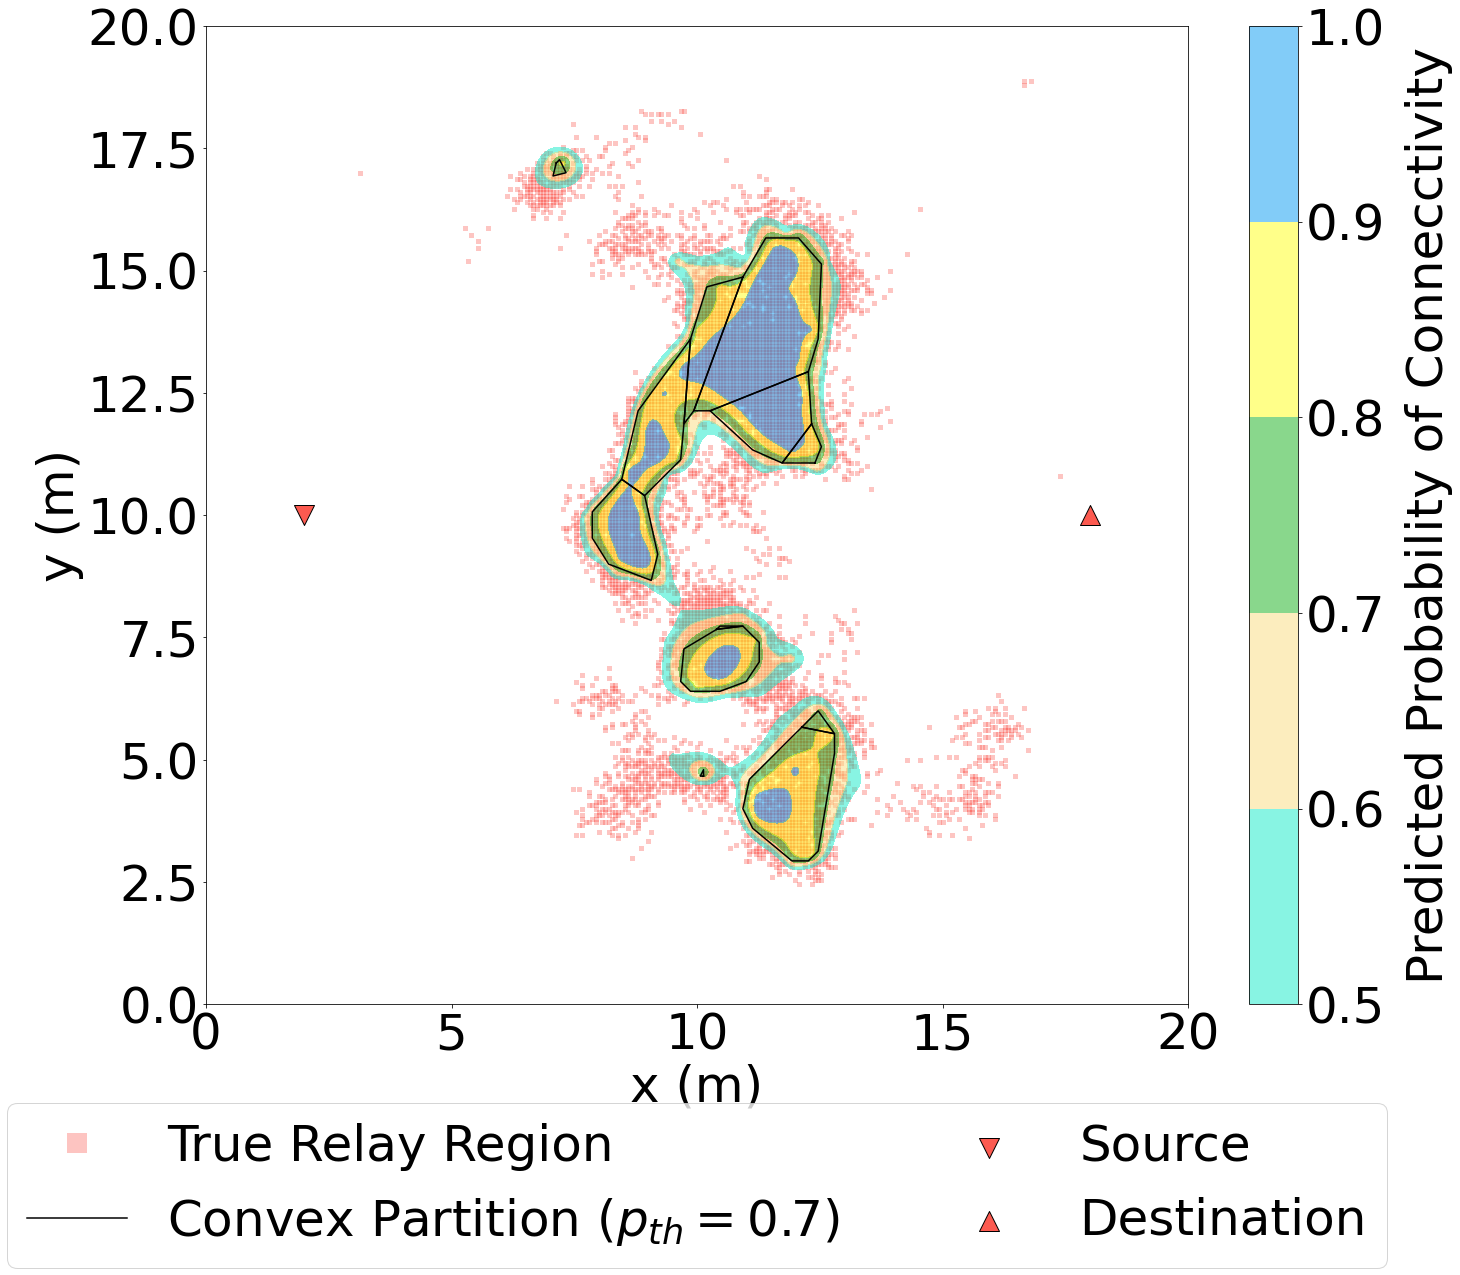

In [8]:
reload(sim)
sim.plotDecompFig(n, tjcps, pfs, qBase, region, pt_cld)
plt.gca().invert_yaxis()
# pt_cld.plot()

sim.save_plt('sim_decomposition.png')
plt.show()

In [9]:
raw_area = len(pjcps[0])*(1/res)**2
print('Original area: %.2f'%(raw_area))

reduced_area = 0
n_cnvx = 0
for poly in pt_cld.polygons:
    reduced_area += poly.area()
    n_cnvx += len(poly.cnvx_partition)
print('Area after reduction: %.2f'%(reduced_area))
print('Number of Convex Polygons in Partition: %d'%(n_cnvx))

Original area: 19.73
Area after reduction: 18.72
Number of Convex Polygons in Partition: 12


In [10]:
#1 Channel from source
#2 channel from destination
#3 Predicted connectiviity from source
#4 Predicted connectiviity to destination
#5 Predicted End to End connectivity
#6 Pointcloud where pconne2e above threshold
#7 Polygon Extracted -> partioned
#8 Post RDP of Polygon -> partioned

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


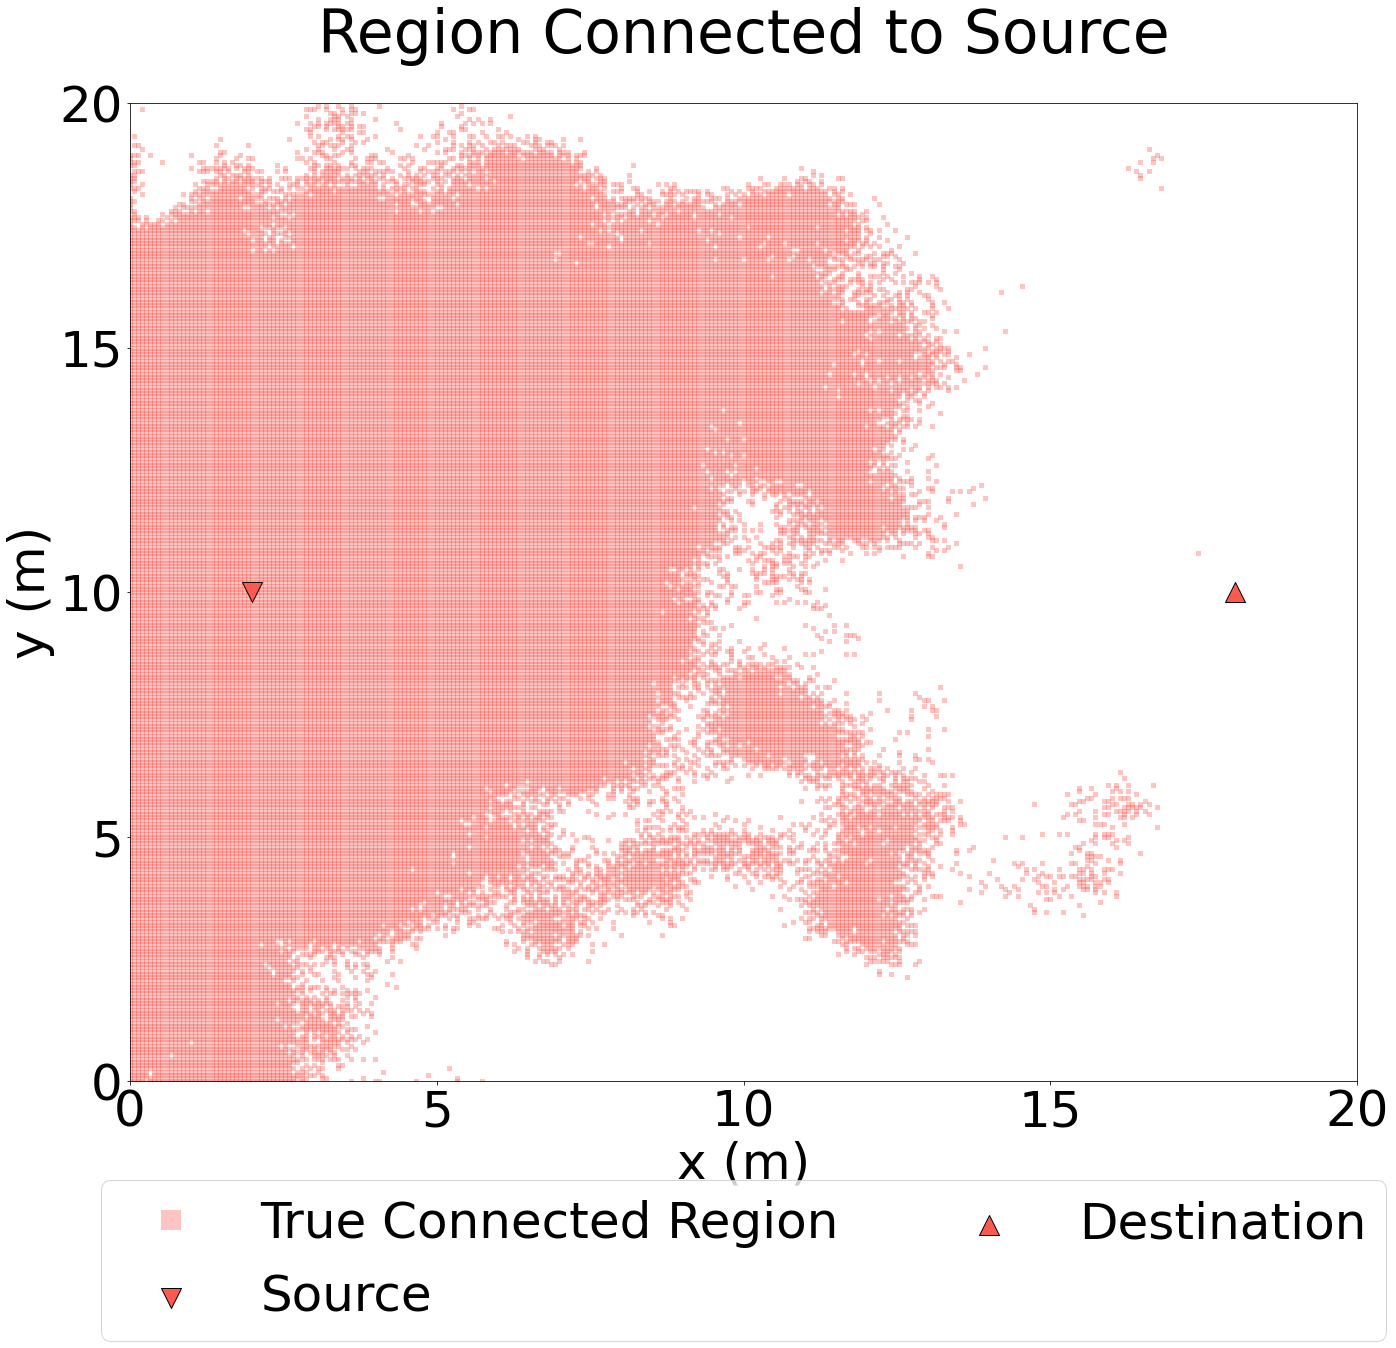

In [11]:
#Channel from Source
pts = ccs[0].getConnectedPoints(GAMMA_TH)

fig = plt.figure(figsize=(22,18))
color = 'xkcd:coral'
plt.plot(pts[:,0], pts[:,1], 's', color=color , markeredgewidth=0.0, markersize=5, alpha=0.35, zorder=-10)
#dummy series for label
plt.plot([-100],  [-100], 's', color=color, markeredgewidth=0.0, markersize=20, alpha=0.35, label='True Connected Region')

#plot base stations
plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Region Connected to Source', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)

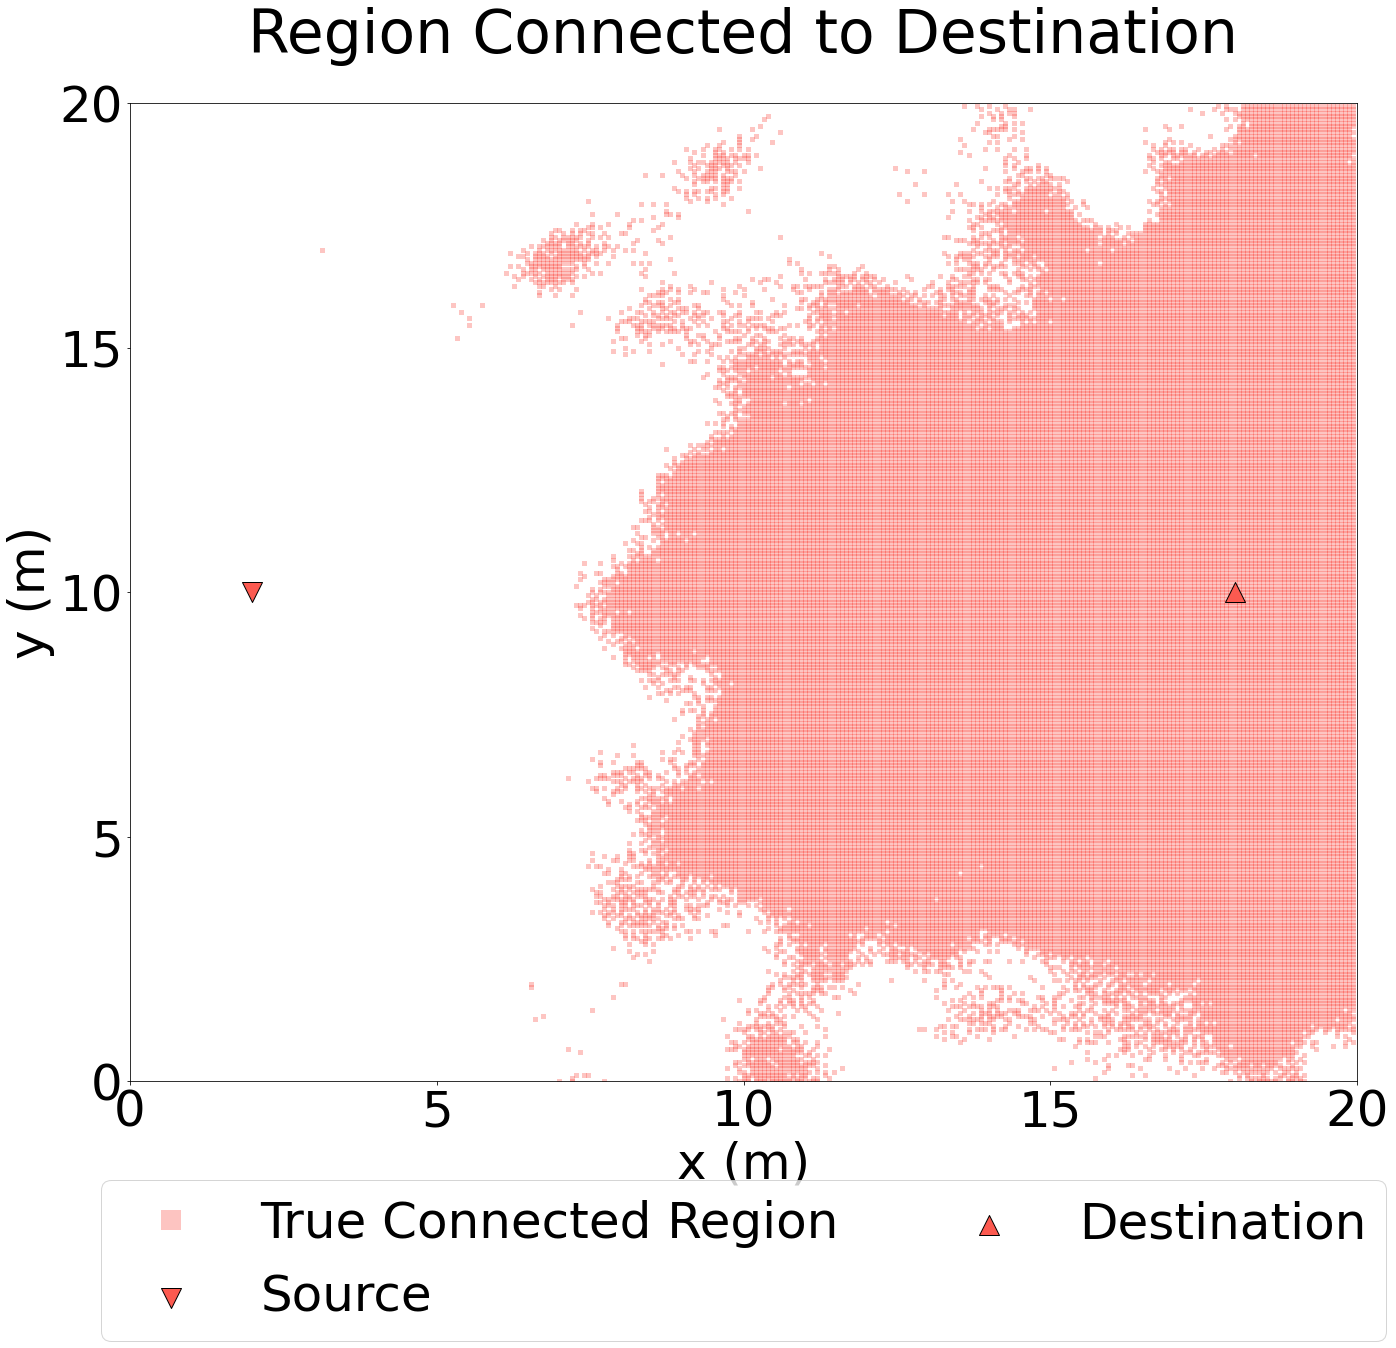

In [12]:
#2 Channel from Destination
pts = ccs[1].getConnectedPoints(GAMMA_TH)

fig = plt.figure(figsize=(22,18))
color = 'xkcd:coral'
plt.plot(pts[:,0], pts[:,1], 's', color=color , markeredgewidth=0.0, markersize=5, alpha=0.35, zorder=-10)
#dummy series for label
plt.plot([-100],  [-100], 's', color=color, markeredgewidth=0.0, markersize=20, alpha=0.35, label='True Connected Region')

#plot base stations
plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Region Connected to Destination', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)

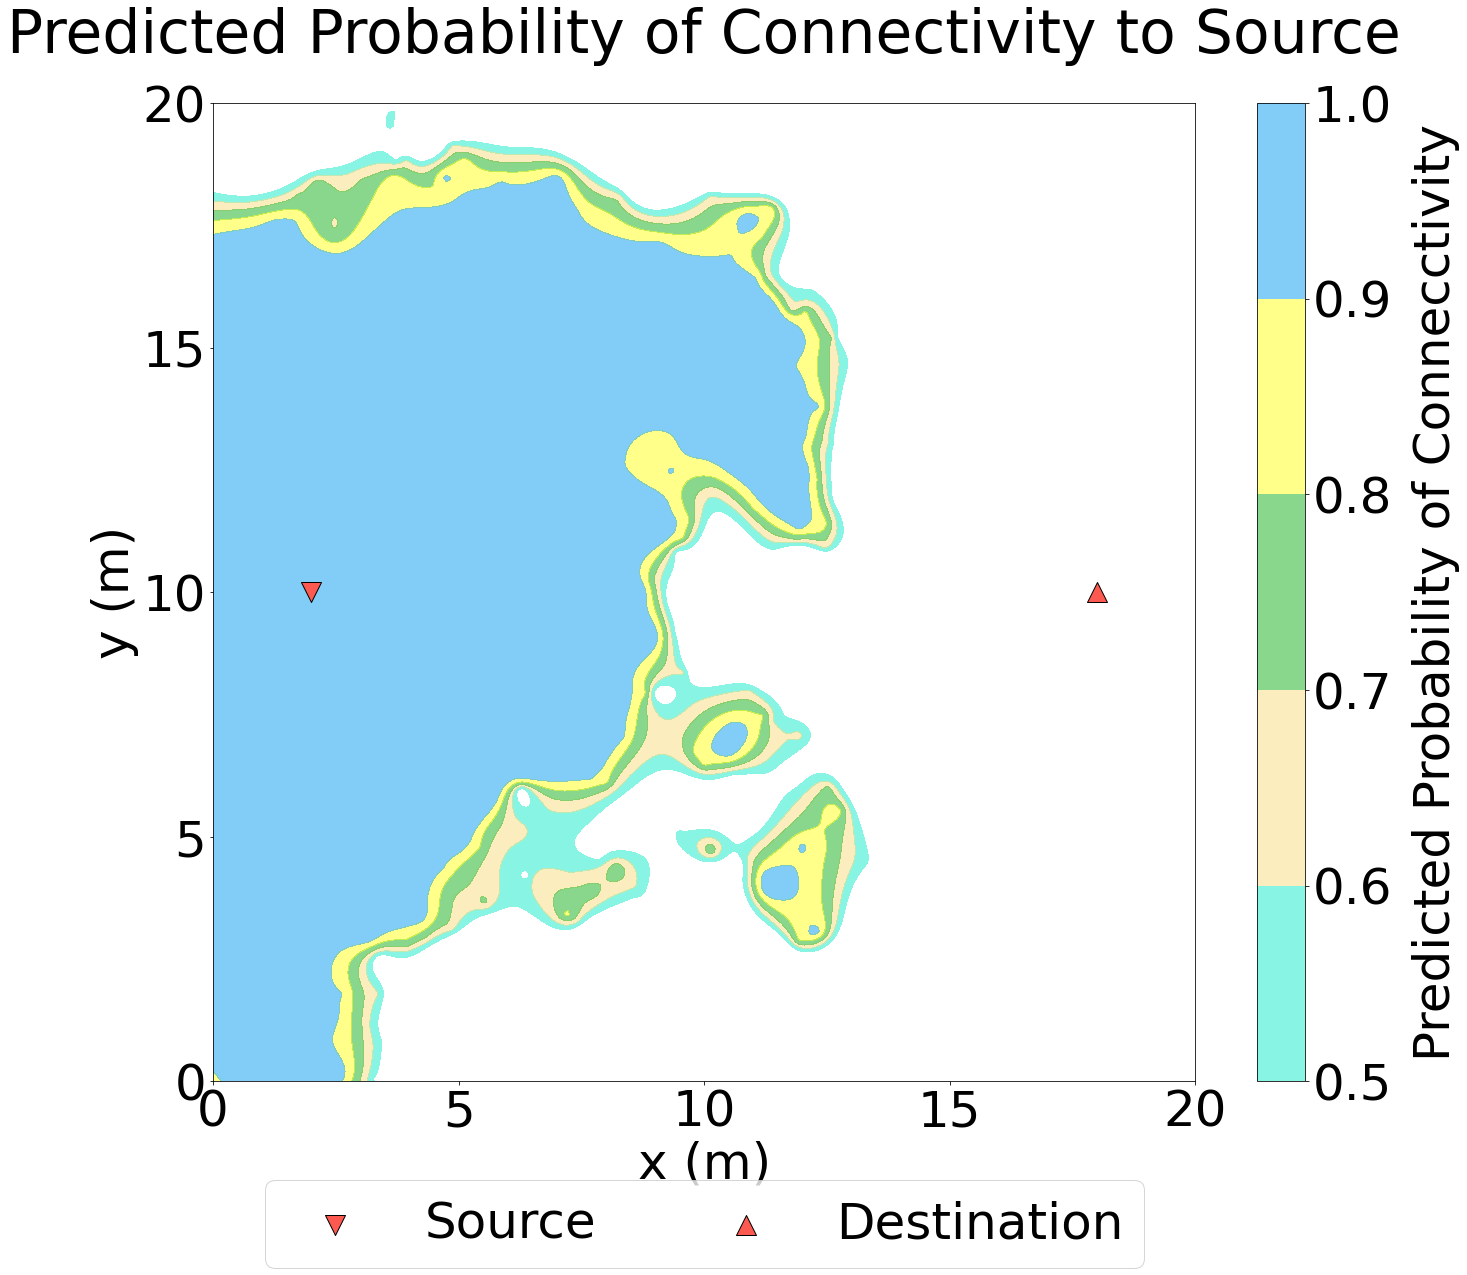

In [13]:
#3 Predicted Probability of connectiivty to source
fig = plt.figure(figsize=(22,18))
p_field = pfs[0]
nx, ny = p_field.shape
X = np.linspace(region[1], region[0], nx)
Y = np.linspace(region[3], region[2], ny)

C = plt.contourf(X, Y, p_field.T,[0.5, 0.6, 0.7, 0.8, 0.9, 1 ], alpha = 0.5, colors = ['xkcd:aqua', 'xkcd:wheat', 'xkcd:green', 'xkcd:yellow', 'xkcd:azure', ])
cb = fig.colorbar(C)
cb.set_label('Predicted Probability of Connecctivity', labelpad=20)

plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Predicted Probability of Connectivity to Source', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)

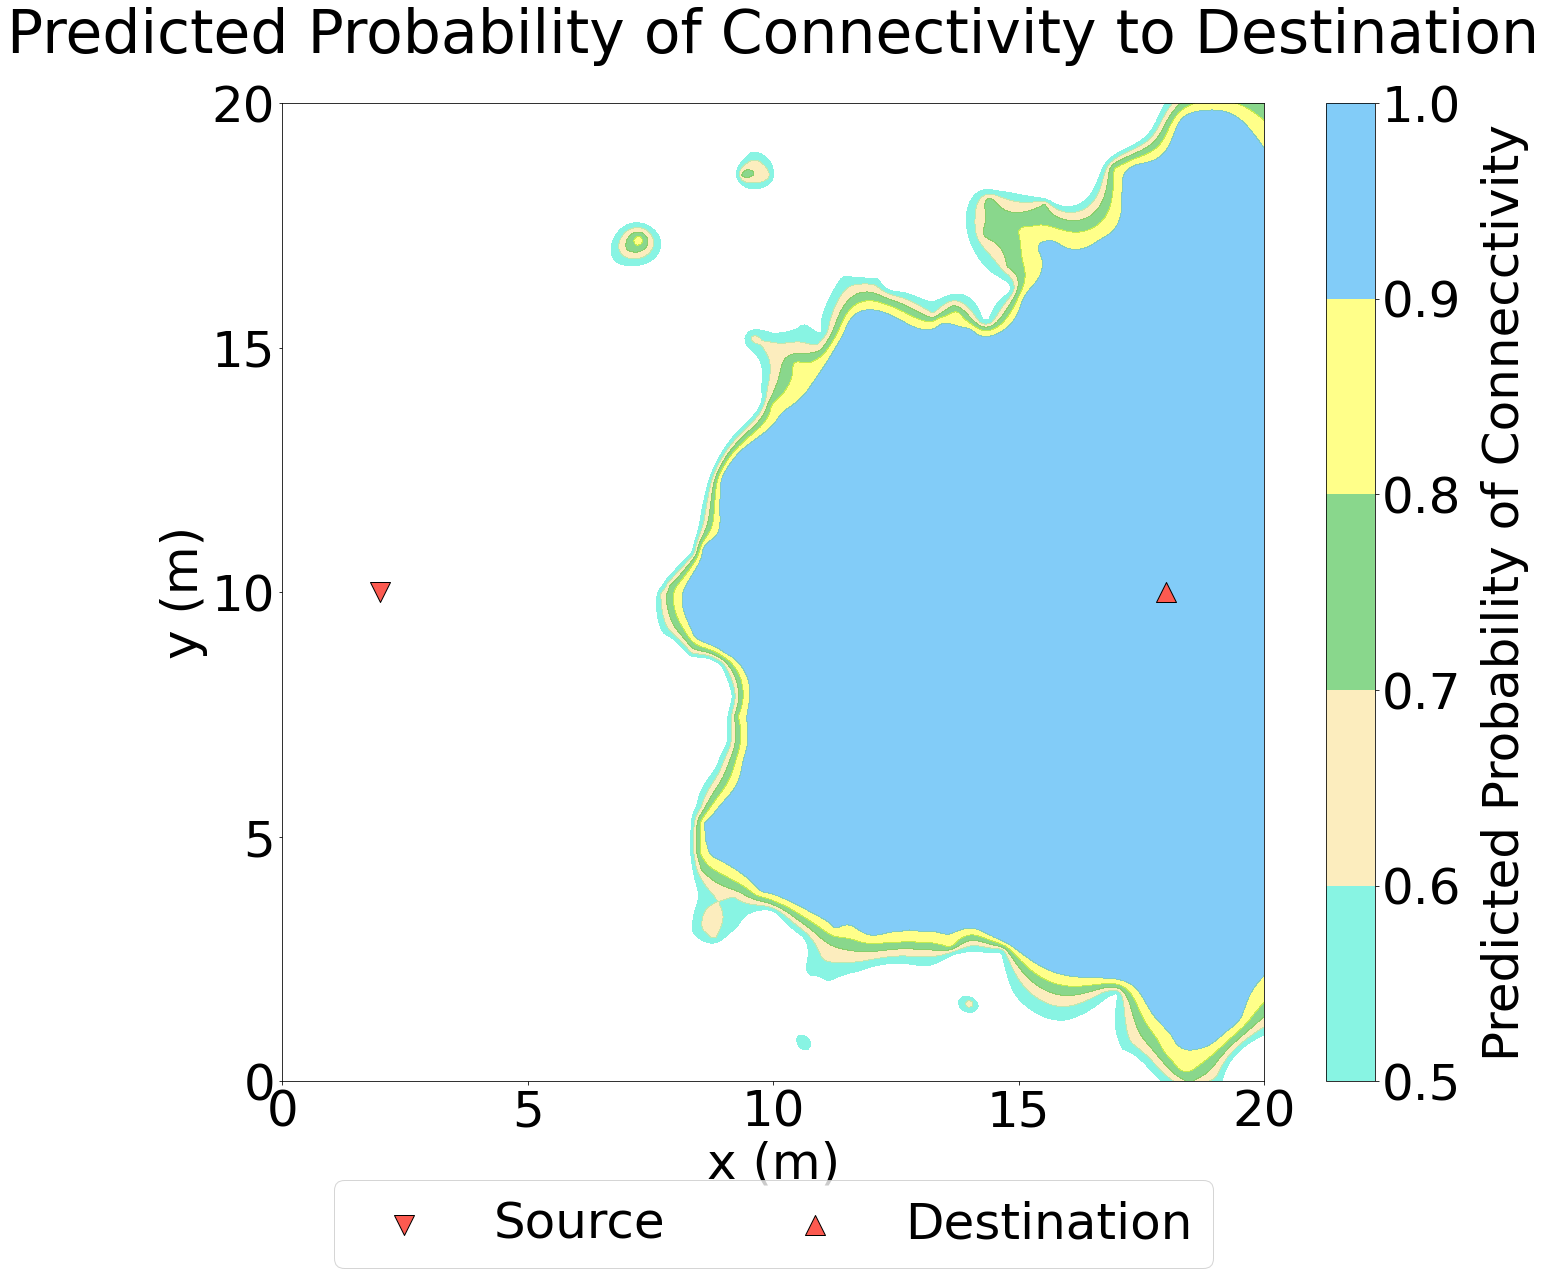

In [14]:
#4 Predicted probability of connectiivty to destination
fig = plt.figure(figsize=(22,18))
p_field = pfs[1]
nx, ny = p_field.shape
X = np.linspace(region[1], region[0], nx)
Y = np.linspace(region[3], region[2], ny)

C = plt.contourf(X, Y, p_field.T,[0.5, 0.6, 0.7, 0.8, 0.9, 1 ], alpha = 0.5, colors = ['xkcd:aqua', 'xkcd:wheat', 'xkcd:green', 'xkcd:yellow', 'xkcd:azure', ])
cb = fig.colorbar(C)
cb.set_label('Predicted Probability of Connecctivity', labelpad=20)

plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Predicted Probability of Connectivity to Destination', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)

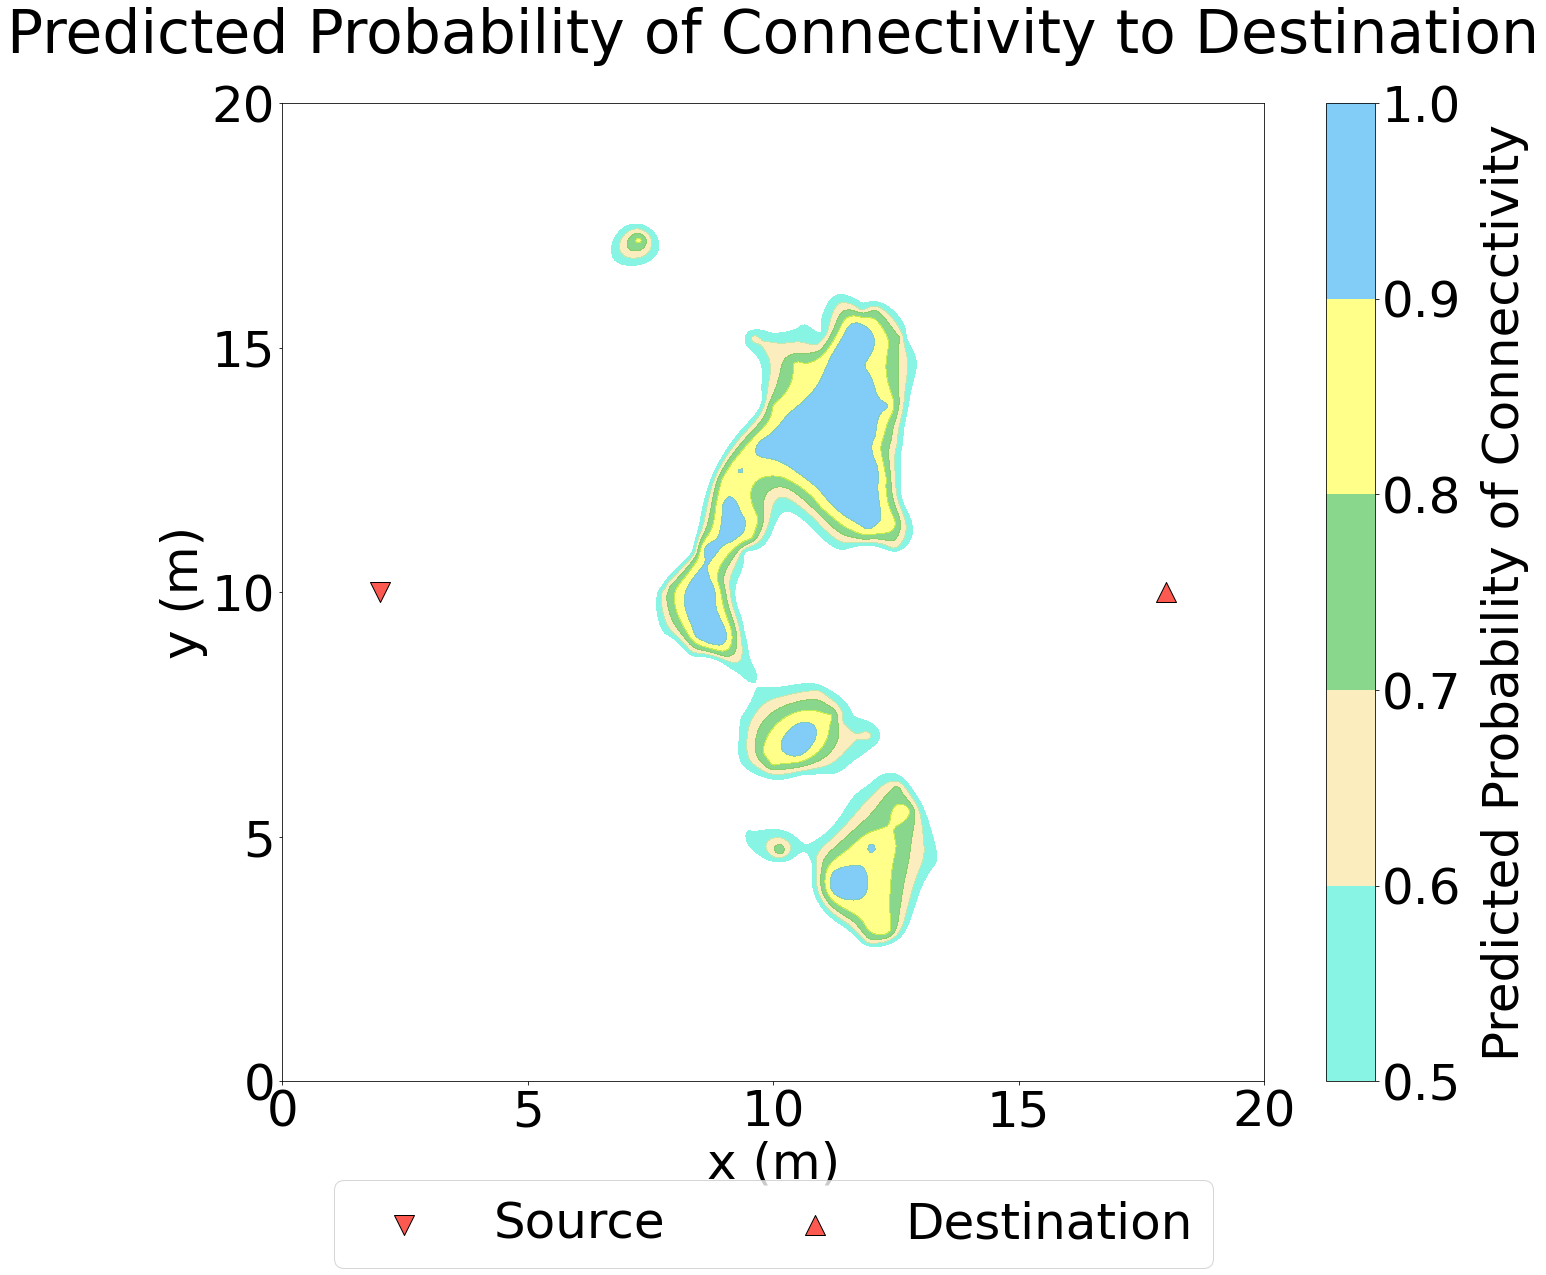

In [15]:
#5 Predicted End to End

fig = plt.figure(figsize=(22,18))
p_field = pfs[0]*pfs[1]
nx, ny = p_field.shape
X = np.linspace(region[1], region[0], nx)
Y = np.linspace(region[3], region[2], ny)

C = plt.contourf(X, Y, p_field.T,[0.5, 0.6, 0.7, 0.8, 0.9, 1 ], alpha = 0.5, colors = ['xkcd:aqua', 'xkcd:wheat', 'xkcd:green', 'xkcd:yellow', 'xkcd:azure', ])
cb = fig.colorbar(C)
cb.set_label('Predicted Probability of Connecctivity', labelpad=20)

plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Predicted Probability of Connectivity to Destination', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)

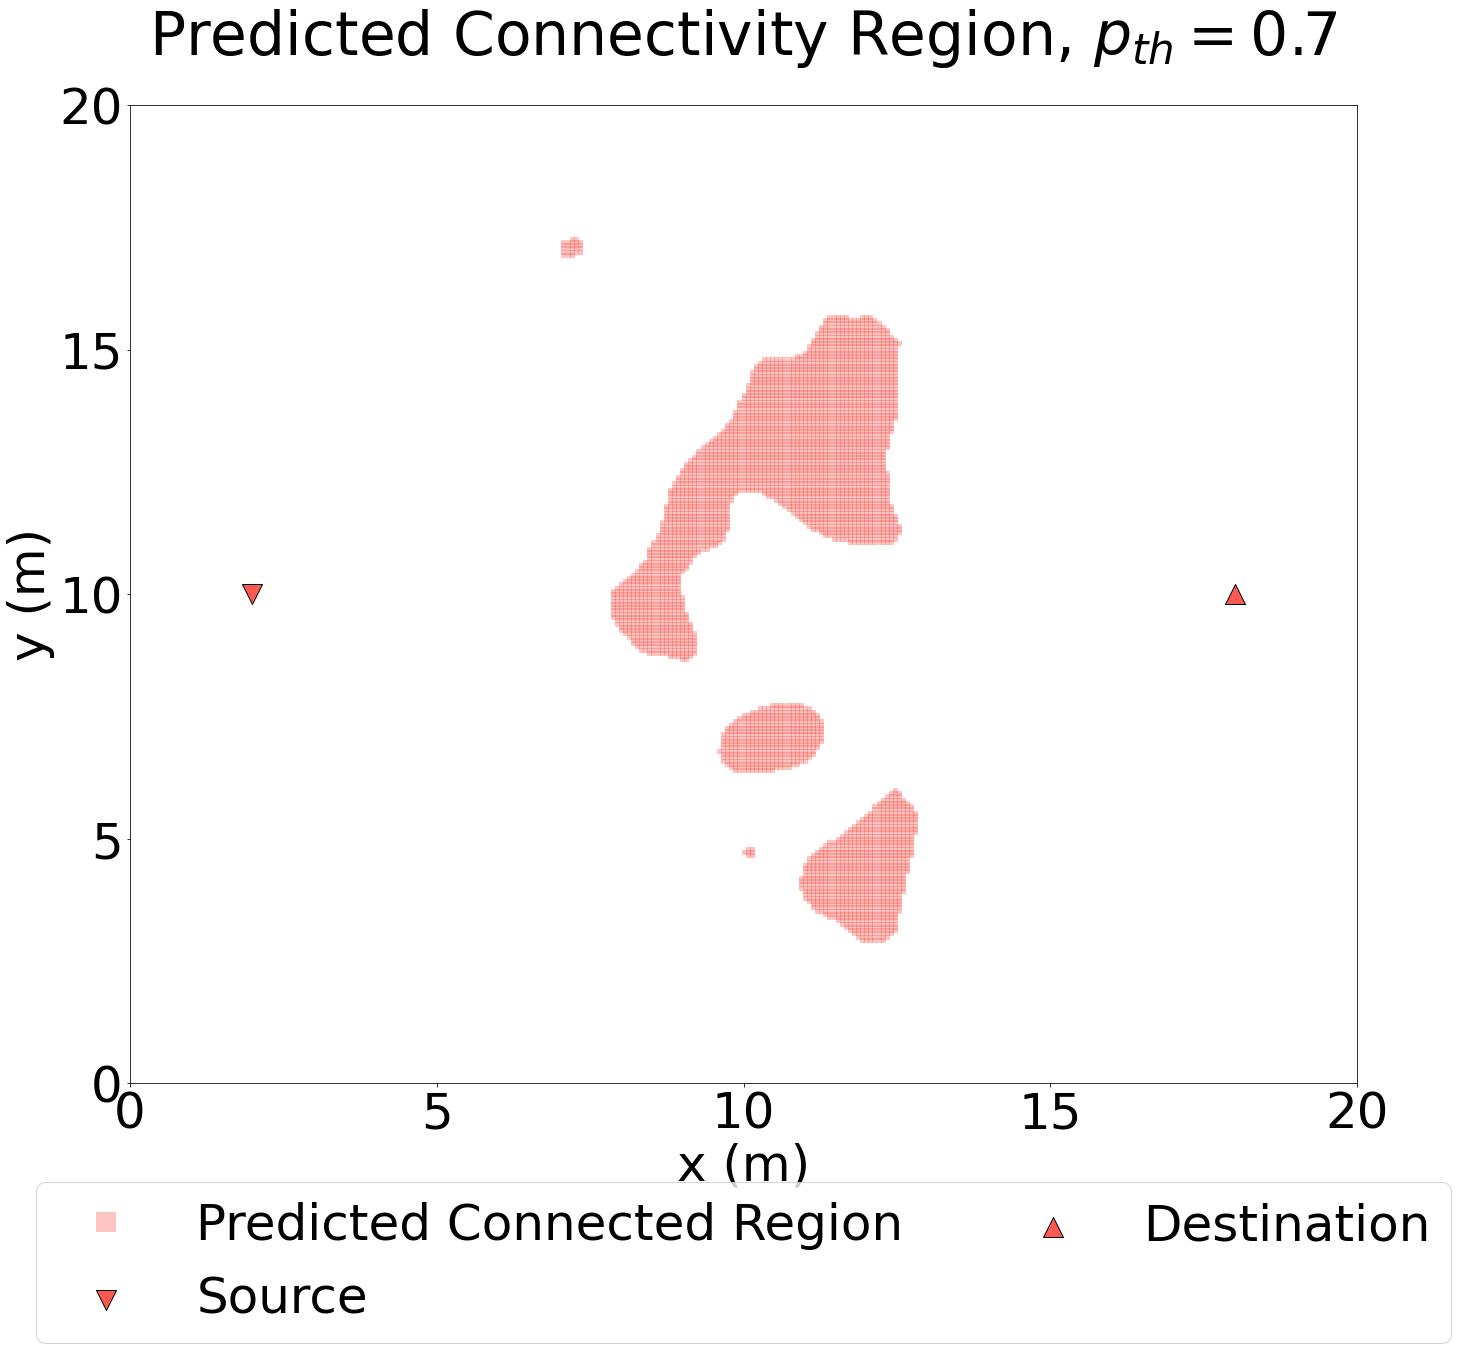

In [16]:
#7 point cloud for some threshold
pts = pjcps[0]

fig = plt.figure(figsize=(22,18))
color = 'xkcd:coral'
plt.plot(pts[:,0], pts[:,1], 's', color=color , markeredgewidth=0.0, markersize=5, alpha=0.35, zorder=-10)
#dummy series for label
plt.plot([-100],  [-100], 's', color=color, markeredgewidth=0.0, markersize=20, alpha=0.35, label='Predicted Connected Region')

#plot base stations
plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Predicted Connectivity Region, $p_{th}=0.7$', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)
sim.save_plt('decomp_pointcloud.png')

Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
61 total subregions


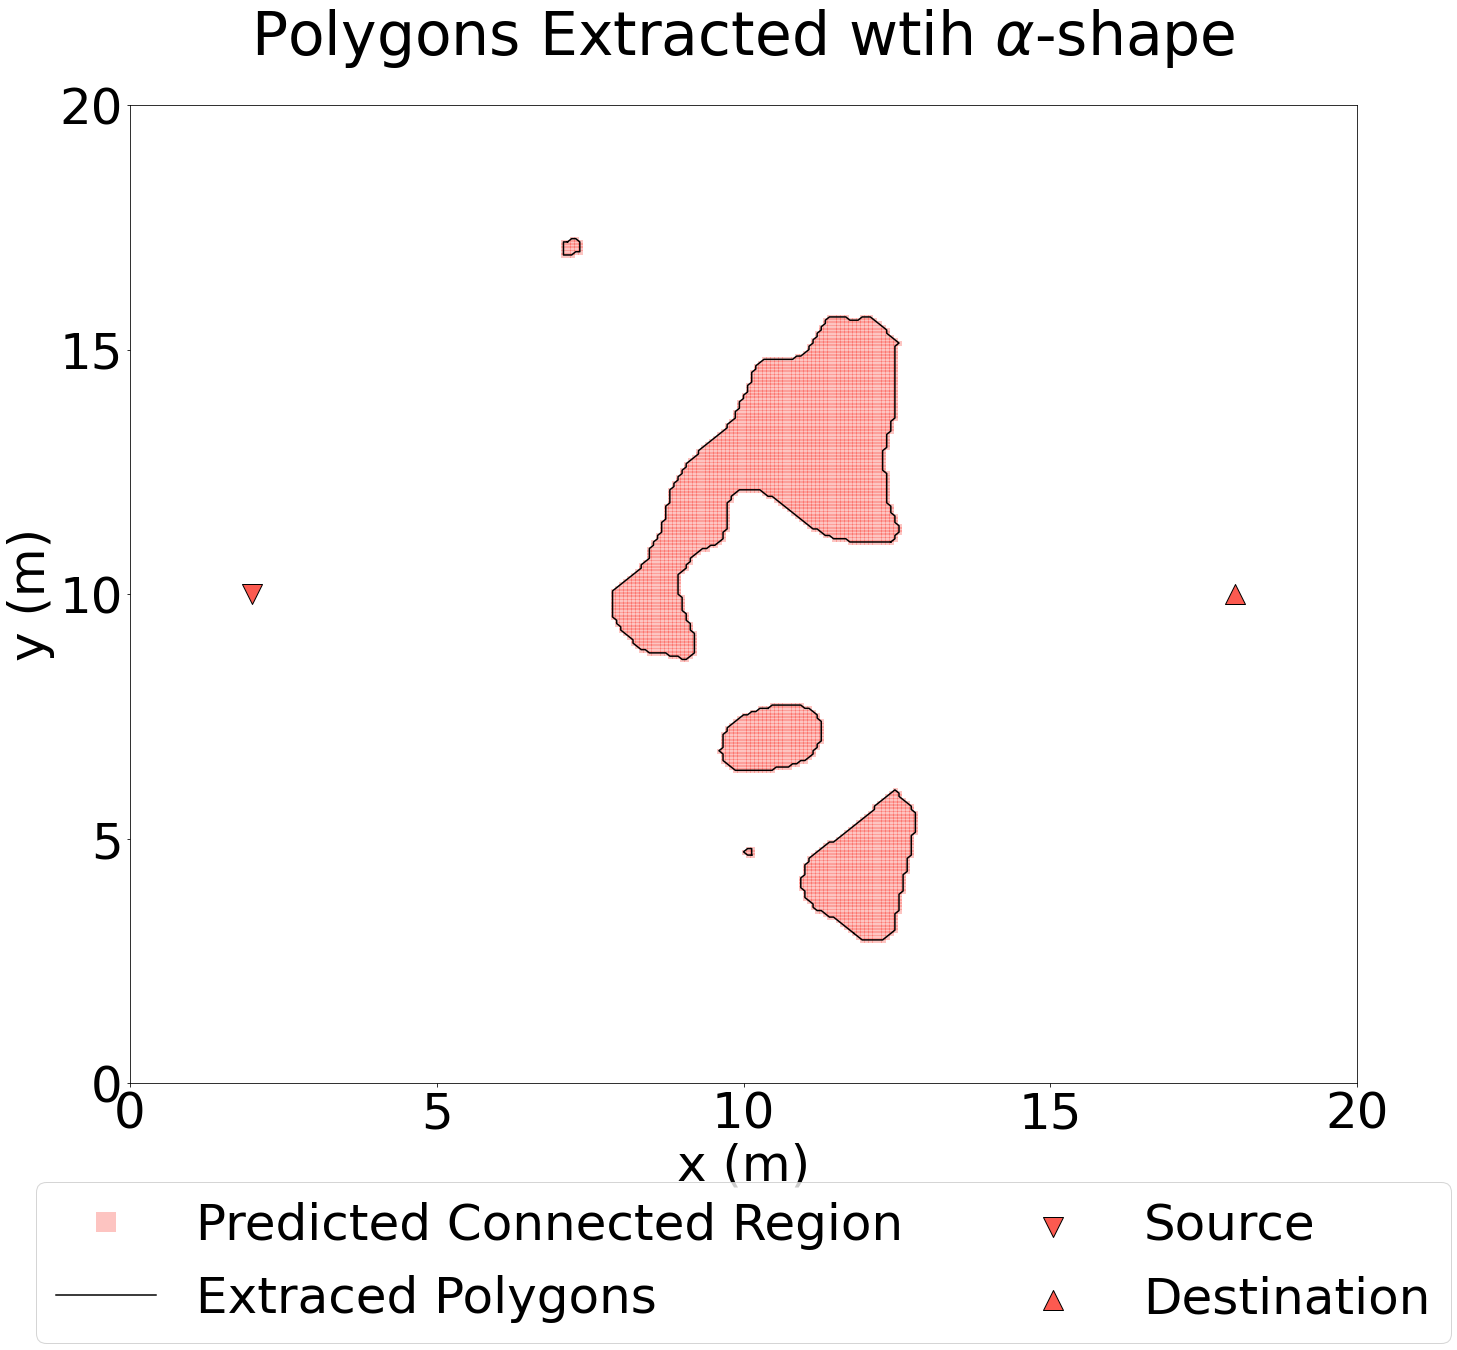

In [17]:
#8 plot Result of alpha shape
reload(PC)
fig = plt.figure(figsize=(22,18))

ts = pjcps[0]
color = 'xkcd:coral'
plt.plot(pts[:,0], pts[:,1], 's', color=color , markeredgewidth=0.0, markersize=5, alpha=0.35, zorder=-10)
#dummy series for label
plt.plot([-100],  [-100], 's', color=color, markeredgewidth=0.0, markersize=20, alpha=0.35, label='Predicted Connected Region')


pt_cld = PC.PointCloud(pjcps[0])
pt_cld.partition(do_reduce=False)
for poly in pt_cld.polygons:
    poly.plot(show_partition=False)
#dummy series for label
plt.plot( [-100, -90],  [-100, -90], '-', color='k', markersize=20, label='Extraced Polygons')

#plot base stations
plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')	    
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Polygons Extracted wtih $\\alpha$-shape', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)
sim.save_plt('decomp_alpha.png')

Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
12 total subregions


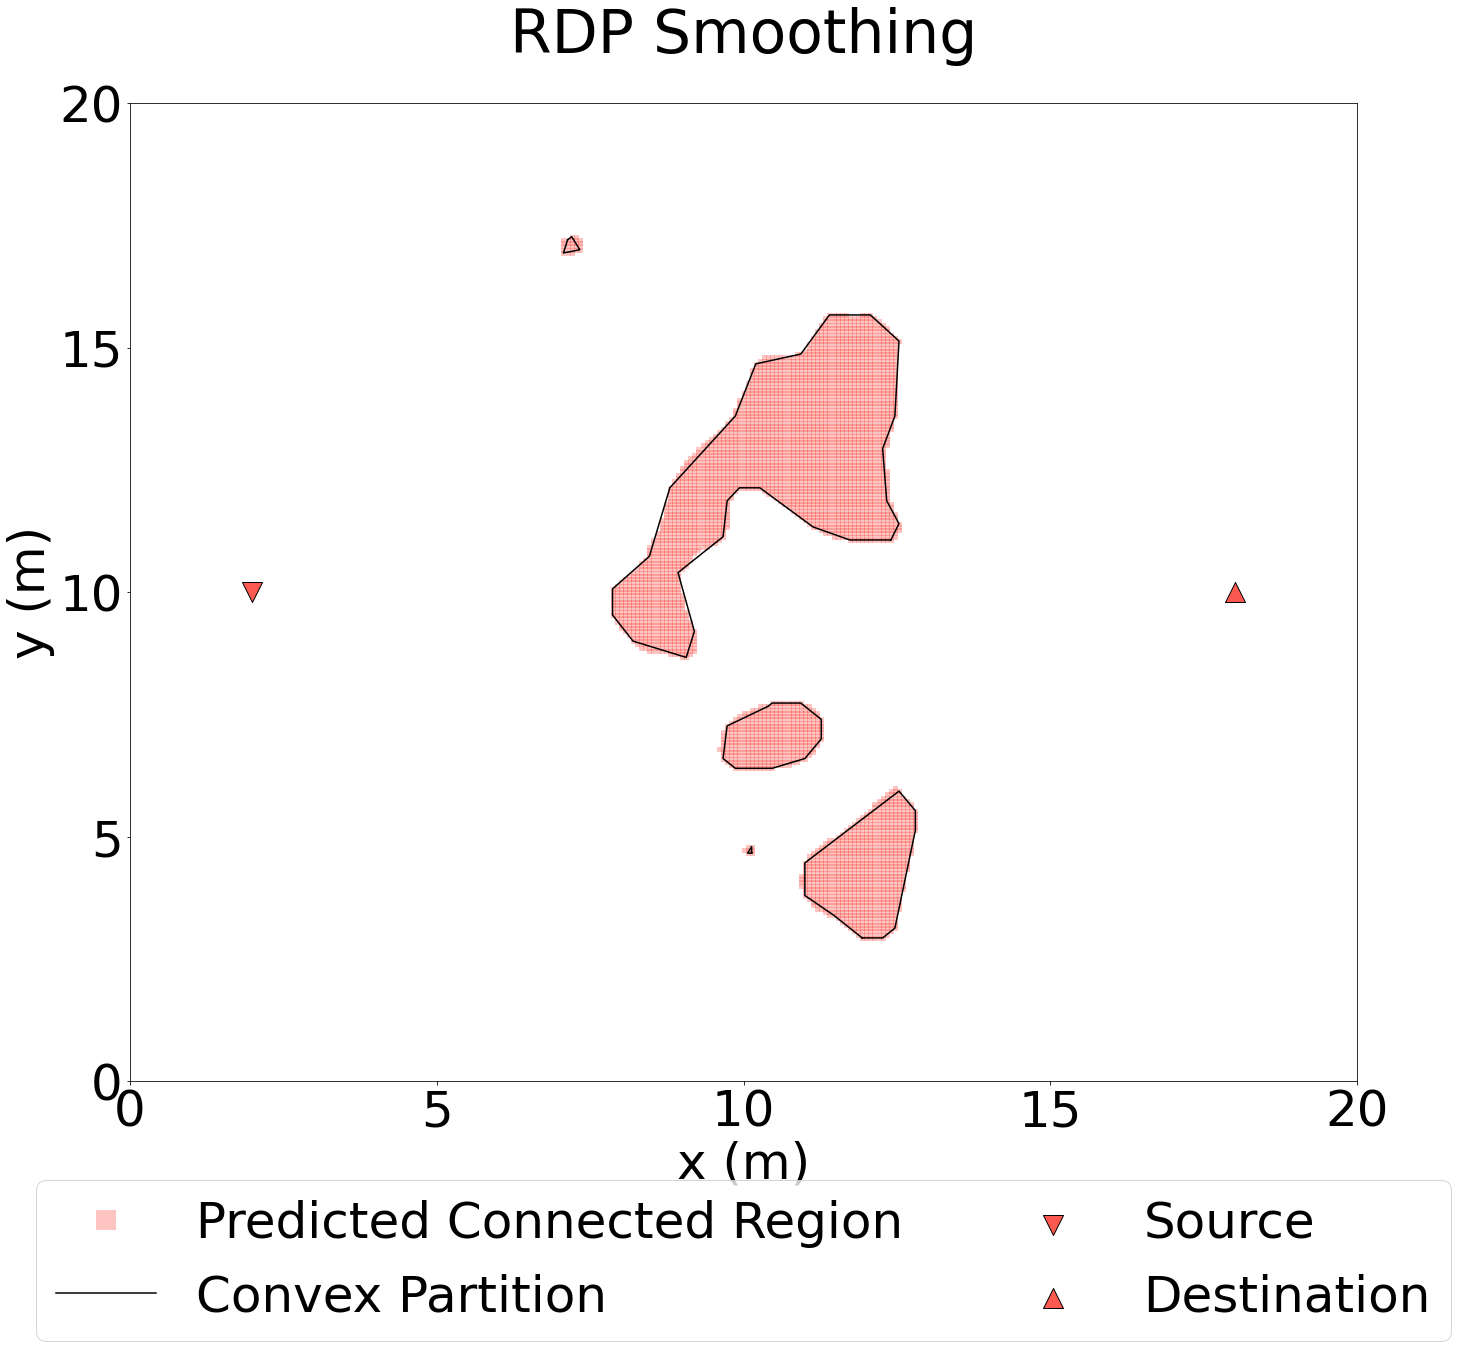

In [18]:
#8 plot Result of alpha shape + RDP smoothing
reload(PC)
fig = plt.figure(figsize=(22,18))

ts = pjcps[0]
color = 'xkcd:coral'
plt.plot(pts[:,0], pts[:,1], 's', color=color , markeredgewidth=0.0, markersize=5, alpha=0.35, zorder=-10)
#dummy series for label
plt.plot([-100],  [-100], 's', color=color, markeredgewidth=0.0, markersize=20, alpha=0.35, label='Predicted Connected Region')


pt_cld = PC.PointCloud(pjcps[0])
pt_cld.partition()
for poly in pt_cld.polygons:
    poly.plot(show_partition=False)
#dummy series for label
plt.plot( [-100, -90],  [-100, -90], '-', color='k', markersize=20, label='Convex Partition')

#plot base stations
plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')	    
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('RDP Smoothing', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)
sim.save_plt('decomp_rdp.png')

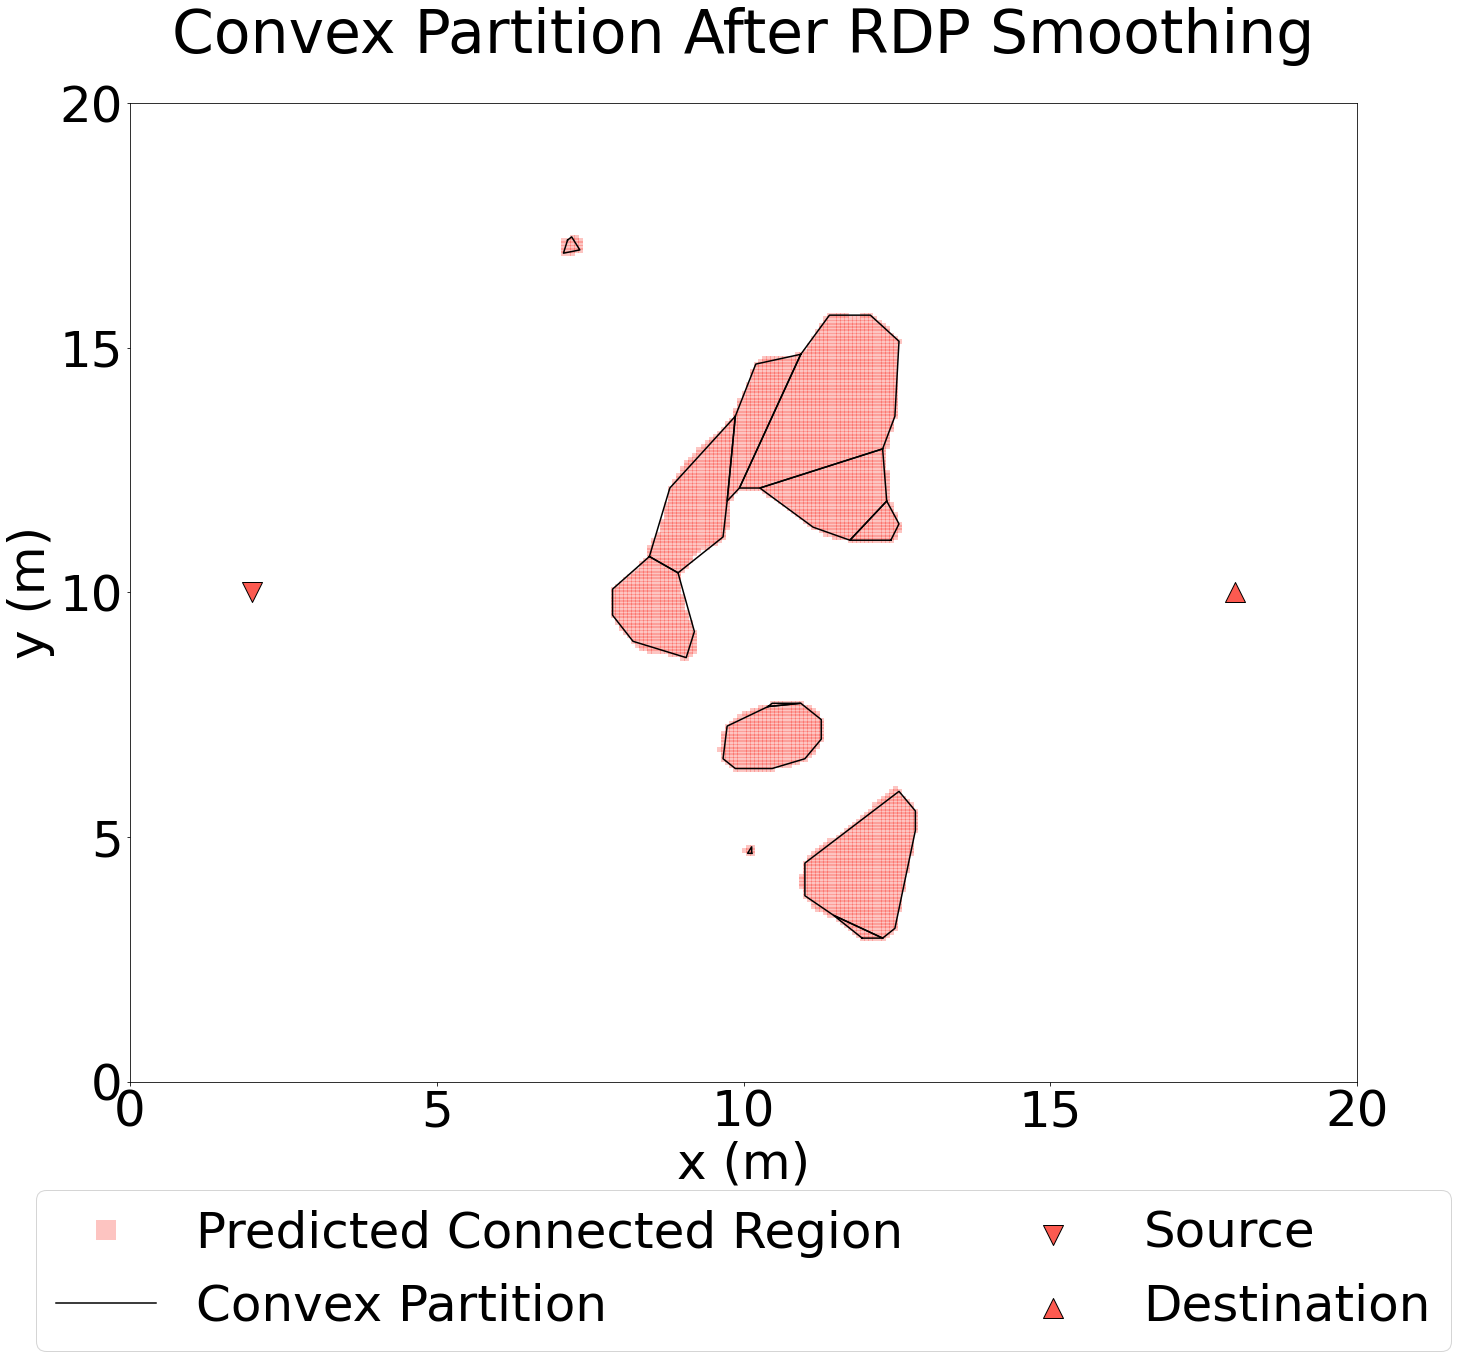

In [19]:
#8 plot Result of alpha shape + RDP smoothing
reload(PC)
fig = plt.figure(figsize=(22,18))

ts = pjcps[0]
color = 'xkcd:coral'
plt.plot(pts[:,0], pts[:,1], 's', color=color , markeredgewidth=0.0, markersize=5, alpha=0.35, zorder=-10)
#dummy series for label
plt.plot([-100],  [-100], 's', color=color, markeredgewidth=0.0, markersize=20, alpha=0.35, label='Predicted Connected Region')


for poly in pt_cld.polygons:
    poly.plot(show_partition=True)
#dummy series for label
plt.plot( [-100, -90],  [-100, -90], '-', color='k', markersize=20, label='Convex Partition')

#plot base stations
plt.scatter([qBase[0][0]], [qBase[0][1]], color=color, marker='v', s=400, edgecolor='k', label='Source')
plt.scatter([qBase[1][0]], [qBase[1][1]], color=color, marker='^', s=400, edgecolor='k', label='Destination')	    
plt.xlim(region[1],region[0])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.ylim(region[2],region[3])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Convex Partition After RDP Smoothing', pad=50)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,-.085], ncol=2)
sim.save_plt('decomp_partition.png')

Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
61 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
12 total subregions


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

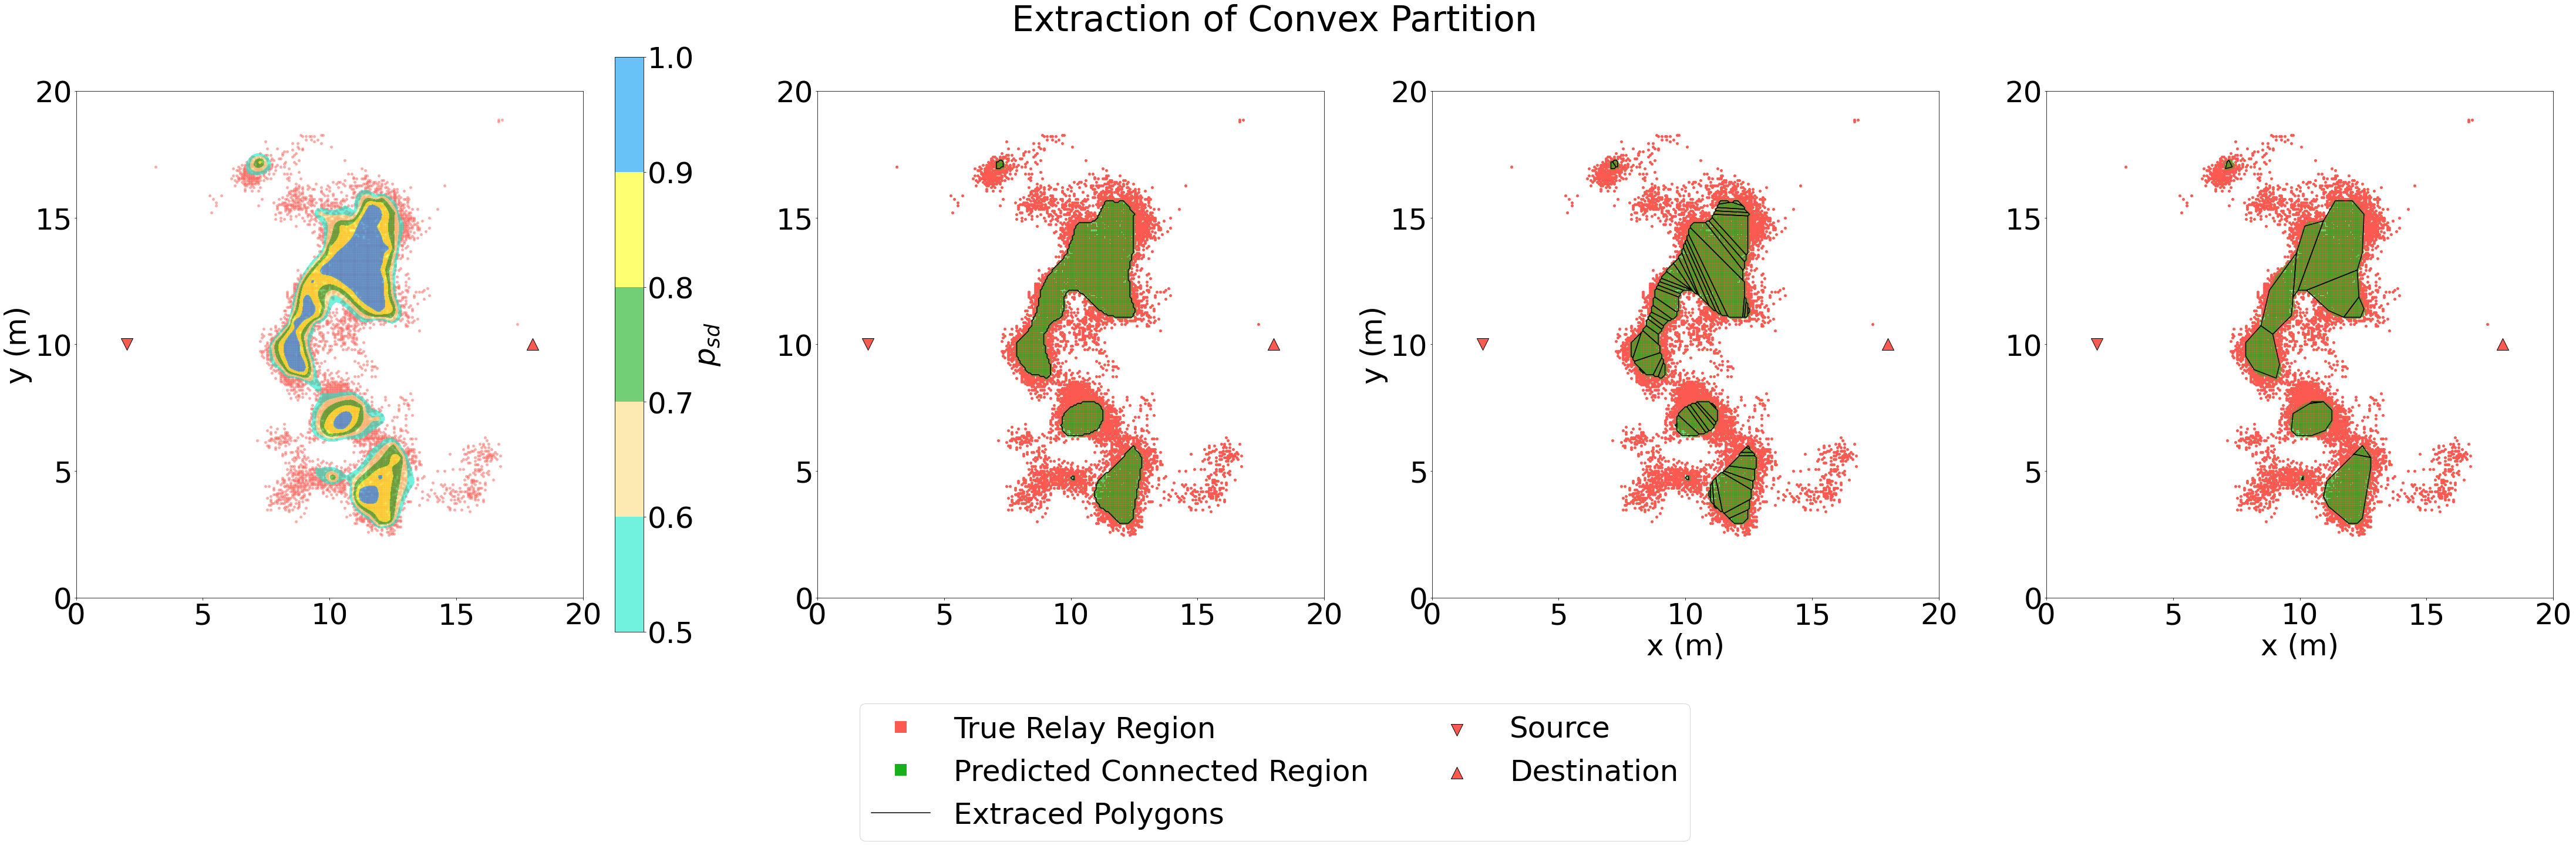

In [36]:
#combine into a single figure for ease of use
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 50})
#7 point cloud for some threshold
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(3*18+18*1.2,18), gridspec_kw={'width_ratios': [5, 4, 4, 4]})

coral = 'xkcd:coral'
grey ='0.8'
grey = 'xkcd:green'

# ax1.plot(pts[:,0], pts[:,1], 's', color=color , markeredgewidth=0.0, markersize=5, alpha=0.35, zorder=-10)
# #dummy series for label
# ax1.plot([-100],  [-100], 's', color=color, markeredgewidth=0.0, markersize=20, alpha=0.35)

p_field = pfs[0]*pfs[1]
nx, ny = p_field.shape
X = np.linspace(region[1], region[0], nx)
Y = np.linspace(region[3], region[2], ny)

C = ax1.contourf(X, Y, p_field.T,[0.5, 0.6, 0.7, 0.8, 0.9, 1 ], alpha = 0.6, colors = ['xkcd:aqua', 'xkcd:wheat', 'xkcd:green', 'xkcd:yellow', 'xkcd:azure', ])
cb = fig.colorbar(C, ax=ax1)
cb.set_label('$p_{sd}$', labelpad=0)

#plot true field
pts = tjcps[0]
ax1.plot(pts[:,0], pts[:,1], '.', color=coral , markeredgewidth=0.0, markersize=10, alpha=0.5, zorder=-100)

#plot base stations
ax1.scatter([qBase[0][0]], [qBase[0][1]], color=coral, marker='v', s=400, edgecolor='k')
ax1.scatter([qBase[1][0]], [qBase[1][1]], color=coral, marker='^', s=400, edgecolor='k')
ax1.set_xlim(region[1],region[0])
ax1.set_xticks([0, 5, 10, 15, 20])
ax1.set_yticks([0, 5, 10, 15, 20])
ax1.set_ylim(region[2],region[3])
#ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.invert_yaxis()
ax1.set_aspect("equal")
#ax1.set_title('Point Cloud', pad=50)
#ax1.legend(loc='upper center', bbox_to_anchor=[0.5,-.075], ncol=2)




pts = pjcps[0]
ax2.plot(pts[:,0], pts[:,1], 's', color=grey , markeredgewidth=0.0, markersize=5, alpha=0.3, zorder=-10)

pt_cld = PC.PointCloud(pjcps[0])
pt_cld.partition(do_reduce=False)
for poly in pt_cld.polygons:
    poly.plot(show_partition=False, ax=ax2)

#plot true field
pts = tjcps[0]
ax2.plot(pts[:,0], pts[:,1], '.', color=coral , markeredgewidth=0.0, markersize=10, alpha=1, zorder=-100)

#plot base stations
ax2.scatter([qBase[0][0]], [qBase[0][1]], color=coral, marker='v', s=400, edgecolor='k')
ax2.scatter([qBase[1][0]], [qBase[1][1]], color=coral, marker='^', s=400, edgecolor='k')
ax2.set_xlim(region[1],region[0])
ax2.set_xticks([0, 5, 10, 15, 20])
ax2.set_yticks([0, 5, 10, 15, 20])
ax2.set_ylim(region[2],region[3])
# ax2.set_xlabel('x (m)')
# ax2.set_ylabel('y (m)')
ax2.invert_yaxis()
ax2.set_aspect("equal")
#ax2.set_title('$\\alpha$-shape', pad=50)

#Partition w/o RDP
pts = pjcps[0]
ax3.plot(pts[:,0], pts[:,1], 's', color=grey , markeredgewidth=0.0, markersize=5, alpha=0.3, zorder=-10)


for poly in pt_cld.polygons:
    poly.plot(show_partition=True, ax=ax3)

#plot true field
pts = tjcps[0]
ax3.plot(pts[:,0], pts[:,1], '.', color=coral , markeredgewidth=0.0, markersize=10, alpha=1, zorder=-100)

#plot base stations
ax3.scatter([qBase[0][0]], [qBase[0][1]], color=coral, marker='v', s=400, edgecolor='k')
ax3.scatter([qBase[1][0]], [qBase[1][1]], color=coral, marker='^', s=400, edgecolor='k')
ax3.set_xlim(region[1],region[0])
ax3.set_xticks([0, 5, 10, 15, 20])
ax3.set_yticks([0, 5, 10, 15, 20])
ax3.set_ylim(region[2],region[3])
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.invert_yaxis()
ax3.set_aspect("equal")
#ax3.set_title('$\\alpha$-shape', pad=50)


#Partition w/ RDP

#dummy series for label
plt.plot([-100],  [-100], 's', color=coral, markeredgewidth=0.0, markersize=20, alpha=1, label='True Relay Region')

pts = pjcps[0]
ax4.plot(pts[:,0], pts[:,1], 's', color=grey , markeredgewidth=0.0, markersize=5, alpha=0.3, zorder=-10)
ax4.plot([-100],  [-100], 's', color=grey, markeredgewidth=0.0, markersize=20, alpha=1, label='Predicted Connected Region')

pt_cld = PC.PointCloud(pjcps[0])
pt_cld.partition(do_reduce=True)
for poly in pt_cld.polygons:
    poly.plot(show_partition=True, ax=ax4)
#dummy series for label
ax4.plot( [-100, -90],  [-100, -90], '-', color='k', markersize=20, label='Extraced Polygons')

#plot true field
pts = tjcps[0]
ax4.plot(pts[:,0], pts[:,1], '.', color=coral , markeredgewidth=0.0, markersize=10, alpha=1, zorder=-100)

#plot base stations
ax4.scatter([qBase[0][0]], [qBase[0][1]], color=coral, marker='v', s=400, edgecolor='k', label='Source')
ax4.scatter([qBase[1][0]], [qBase[1][1]], color=coral, marker='^', s=400, edgecolor='k', label='Destination')   
ax4.set_xlim(region[1],region[0])
ax4.set_xticks([0, 5, 10, 15, 20])
ax4.set_yticks([0, 5, 10, 15, 20])
ax4.set_ylim(region[2],region[3])
ax4.set_xlabel('x (m)')
#ax4.set_ylabel('y (m)')
ax4.invert_yaxis()
ax4.set_aspect("equal")
#ax4.set_title('Partition', pad=50)
fig.suptitle('Extraction of Convex Partition', y=0.95)
handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5,0.05], ncol=2)
sim.save_plt('decomp_4subs.png')
plt.savefig('decomp_4subs.eps', format='eps', bbox_inches='tight')